In [1]:
!pwd
import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tf_2_work/mlflow_test


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

### quickstart
- https://www.mlflow.org/docs/latest/quickstart.html
```
$ activate mlflow
$ cd C:\Users\shingo\jupyter_notebook\tf_2_work\mlflow_test
$ mlflow ui
```

In [2]:
import os
from mlflow import log_metric, log_param, log_artifact

if __name__ == "__main__":
    # Log a parameter (key-value pair)
    log_param("param1", 5)

    # Log a metric; metrics can be updated throughout the run
    log_metric("foo", 1)
    log_metric("foo", 2)
    log_metric("foo", 3)

    # Log an artifact (output file)
    with open("output.txt", "w") as f:
        f.write("Hello world!")
    log_artifact("output.txt")

In [3]:
%%time
# MNISTの分類

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal # 正規分布でテンソルを生成する初期化子
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential

import math
import numpy as np
from tqdm.notebook import tqdm

class TfMnist():
    """ tf.GradientTapeを使ったMNIST """
    def __init__(self, params, width=28, height=28, depth=1, n_class=10):
        self.width = width
        self.height = height
        self.depth = depth
        self.n_class = n_class
        self.params = params
        self.optimizer = params['optimizer']
        self.model = self.build_model((self.width, self.height, self.depth)
                                      , self.n_class
                                      , params['weight_init'])

    def build_model(self, input_shape, n_class, weight_init):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'
                         , kernel_initializer=weight_init
                         , input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu'
                         , kernel_initializer=weight_init))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'
                        , kernel_initializer=weight_init))
        model.add(Dropout(0.5))
        model.add(Dense(n_class, activation='softmax'
                        , kernel_initializer=weight_init))
        return model

    def step(self, real_x, real_y):
        with tf.GradientTape() as tape:
            # Make prediction
            pred_y = self.model(real_x.reshape((-1, self.width, self.height, self.depth)))
            # Calculate loss
            model_loss = tf.keras.losses.categorical_crossentropy(real_y, pred_y)

        # Calculate gradients
        model_gradients = tape.gradient(model_loss, self.model.trainable_variables)
        # Update model
        self.optimizer.apply_gradients(zip(model_gradients, self.model.trainable_variables))

    def main(self):
        # Load and pre-process training data
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train = (x_train / 255).reshape((-1, self.width, self.height, self.depth))
        y_train = tf.keras.utils.to_categorical(y_train, self.n_class)
        x_test = (x_test / 255).reshape((-1, self.width, self.height, self.depth))
        y_test = tf.keras.utils.to_categorical(y_test, self.n_class)
        
        batch_size = self.params['batch_size']
        epochs = self.params['epochs']
        
        # Training loop
        bat_per_epoch = math.floor(len(x_train) / batch_size)
        for epoch in tqdm(range(epochs)):
            for i in range(bat_per_epoch):
                n = i*batch_size
                self.step(x_train[n:n+batch_size], y_train[n:n+batch_size])

            # Calculate accuracy
            self.model.compile(optimizer=self.optimizer
                               , loss=tf.keras.losses.categorical_crossentropy
                               , metrics=['acc']) # Compile just for evaluation
            print(f"epoch:{epoch} [val_loss, val_acc]:{self.model.evaluate(x_test, y_test, verbose=0)}")
        return self.model
        
# Hyperparameters
params = {'batch_size':128
          , 'epochs':5
          , 'optimizer':Adam(lr=0.001)
          , 'weight_init':RandomNormal()
         }
model = TfMnist(params).main()



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



C:\Users\shingo\Anaconda3\envs\tfgpu20\lib\site-packages\tensorflow_core\python\training\tracking\data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


epoch:0 [val_loss, val_acc]:[0.0598333622940816, 0.9798]
epoch:1 [val_loss, val_acc]:[0.03849499465520494, 0.9857]
epoch:2 [val_loss, val_acc]:[0.03906193565651192, 0.9864]
epoch:3 [val_loss, val_acc]:[0.04246286686105596, 0.987]
epoch:4 [val_loss, val_acc]:[0.0491796516071674, 0.9858]

Wall time: 53.2 s


## TensorFlow2.0で訓練の途中に学習率を変える方法
- https://blog.shikoan.com/how-to-change-learningrate-in-tensorflow2-0/

In [4]:
# 従来どおりLearning Rate Scheduler

import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np

def create_model():
    inputs = layers.Input((784,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(10, activation="softmax")(x)
    return tf.keras.models.Model(inputs, x)

def load_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 784) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 784) / 255.0
    return (X_train, y_train), (X_test, y_test)

def main_keras():
    (X_train, y_train), (X_test, y_test) = load_data()
    model = create_model()
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    # Learning Rate Schedulerに食わせるための関数
    def lr_scheduler(epoch):
        if epoch <= 5: return 0.1
        else: return 1e-8

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128,
              callbacks=[lr_callback])
    
main_keras()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 31us/sample - loss: 0.4328 - sparse_categorical_accuracy: 0.8776 - val_loss: 0.2285 - val_sparse_categorical_accuracy: 0.9331
Epoch 2/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.2100 - sparse_categorical_accuracy: 0.9386 - val_loss: 0.1733 - val_sparse_categorical_accuracy: 0.9472
Epoch 3/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.1570 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.1383 - val_sparse_categorical_accuracy: 0.9582
Epoch 4/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.1262 - sparse_categorical_accuracy: 0.9626 - val_loss: 0.1276 - val_sparse_categorical_accuracy: 0.9616
Epoch 5/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.1051 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1083 - val_sparse_categorical_accuracy: 0.9665


In [5]:
import os
import pandas as pd
from tqdm.notebook import tqdm

def cosine_annealing(lr_start, epoch:int, epochs:int, factor=0.01):
    """Cosine Annealing (without restart)"""
    lr_min = lr_start * factor
    r = (epoch + 1) / epochs
    return lr_min + 0.5 * (lr_start - lr_min) * (1 + np.cos(np.pi * r))

def main_train_loop(output_dir):
    (X_train, y_train), (X_test, y_test) = load_data()

    trainset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    trainset = trainset.shuffle(X_train.shape[0]).batch(128)

    testset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    testset = testset.batch(128)

    model = create_model()
    optim = tf.keras.optimizers.SGD(lr=0.1)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    acc = tf.keras.metrics.SparseCategoricalAccuracy()

    df_log = pd.DataFrame(columns=['epoch', 'loss', 'acc', 'val_loss', 'val_acc', 'lr'])
    early_stopping_count = 0
    
    @tf.function
    def train_on_batch(X, y_true):
        with tf.GradientTape() as tape:
            y_pred = model(X, training=True)
            loss = loss_func(y_true, y_pred)
        grad = tape.gradient(loss, model.trainable_weights)
        optim.apply_gradients(zip(grad, model.trainable_weights))
        acc.update_state(y_true, y_pred)
        return loss

    @tf.function
    def validation_on_batch(X, y_true):
        y_pred = model(X, training=False)
        loss = loss_func(y_true, y_pred)
        acc.update_state(y_true, y_pred)
        return loss

    for epoch in tqdm(range(10)):
        acc.reset_states()
        losses = []
        for X, y in trainset:
            losses.append(train_on_batch(X, y).numpy())
        train_loss, train_acc = np.mean(np.array(losses)), acc.result().numpy()

        acc.reset_states()
        losses = []
        for X, y in testset:
            losses.append(validation_on_batch(X, y).numpy())
        val_loss, val_acc = np.mean(np.array(losses)), acc.result().numpy()
        print(f"Epoch = {epoch+1}, train_loss = {train_loss:.04}, train_acc = {train_loss:.04}, " +
              f"val_loss = {val_loss:.04}, val_acc={val_acc:.04}, lr={optim.lr.numpy():.2e}")

        df_log = df_log.append(pd.Series([epoch+1
                                          , train_loss, train_acc
                                          , val_loss, val_acc
                                          , optim.lr.numpy()], index=df_log.columns)
                               , ignore_index=True)
        df_log.to_csv(os.path.join(output_dir, 'tsv_logger.tsv'), index=False, sep='\t')
        
        # change learning rate
        #if epoch >= 5: optim.lr = 1e-8
        optim.lr = cosine_annealing(0.1, epoch, 10)
            
        if np.min(df_log['val_loss']) >= val_loss: 
            model.save(os.path.join(output_dir, 'best_val_loss.h5'))
            early_stopping_count = 0
            print("INFO: save model. [{}]".format(os.path.join(output_dir, 'best_val_loss.h5')))
        else:
            early_stopping_count += 1
        
        if early_stopping_count >= 3:
            break
    
    return model, df_log

output_dir = r'D:\work\tmp\tfminst'
model, df_log = main_train_loop(output_dir)
df_log

Epoch = 1, train_loss = 0.4646, train_acc = 0.4646, val_loss = 0.2459, val_acc=0.9292, lr=1.00e-01
INFO: save model. [D:\work\tmp\tfminst\best_val_loss.h5]
Epoch = 2, train_loss = 0.2215, train_acc = 0.2215, val_loss = 0.1863, val_acc=0.9452, lr=9.76e-02
INFO: save model. [D:\work\tmp\tfminst\best_val_loss.h5]
Epoch = 3, train_loss = 0.1661, train_acc = 0.1661, val_loss = 0.154, val_acc=0.9543, lr=9.05e-02
INFO: save model. [D:\work\tmp\tfminst\best_val_loss.h5]
Epoch = 4, train_loss = 0.1343, train_acc = 0.1343, val_loss = 0.1397, val_acc=0.9563, lr=7.96e-02
INFO: save model. [D:\work\tmp\tfminst\best_val_loss.h5]
Epoch = 5, train_loss = 0.1147, train_acc = 0.1147, val_loss = 0.1165, val_acc=0.9665, lr=6.58e-02
INFO: save model. [D:\work\tmp\tfminst\best_val_loss.h5]
Epoch = 6, train_loss = 0.09998, train_acc = 0.09998, val_loss = 0.1102, val_acc=0.9676, lr=5.05e-02
INFO: save model. [D:\work\tmp\tfminst\best_val_loss.h5]
Epoch = 7, train_loss = 0.09071, train_acc = 0.09071, val_loss 

,epoch,loss,acc,val_loss,val_acc,lr
0,1.0,0.464580,0.868817,0.245874,0.9292,0.100000
1,2.0,0.221479,0.936000,0.186292,0.9452,0.097577
2,3.0,0.166141,0.951600,0.153954,0.9543,0.090546
3,4.0,0.134303,0.961567,0.139726,0.9563,0.079595
4,5.0,0.114672,0.966817,0.116496,0.9665,0.065796
5,6.0,0.099983,0.971483,0.110247,0.9676,0.050500
6,7.0,0.090713,0.974350,0.105589,0.9696,0.035204
7,8.0,0.084325,0.976000,0.103865,0.9693,0.021405
8,9.0,0.080630,0.977817,0.101224,0.9701,0.010454
9,10.0,0.078644,0.978033,0.100786,0.9703,0.003423


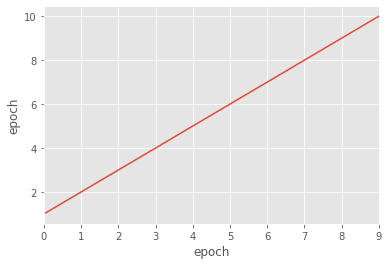

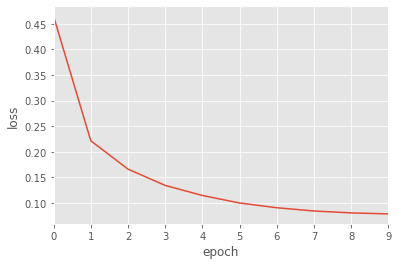

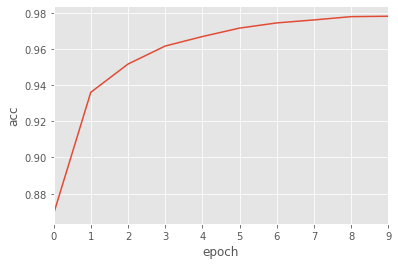

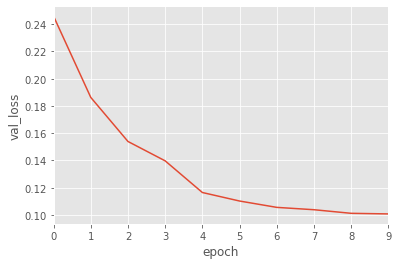

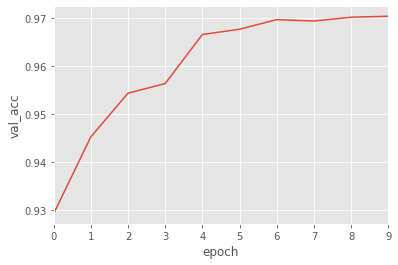

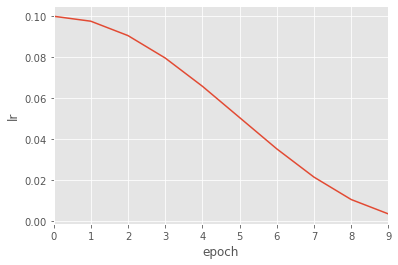

In [6]:
def save_df_plot(col, df, output_dir):
    """ データフレームの各列をplotしてpngで保存 """
    import matplotlib
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    df[col].plot()
    plt.xlabel('epoch')
    plt.ylabel(col)
    plt.savefig(os.path.join(output_dir, col+'.png'), bbox_inches="tight")
    plt.show()
    
for col in df_log.columns:
    save_df_plot(col, df_log, output_dir)

In [7]:
import mlflow
import mlflow.keras

def set_mlflow_param(output_dir, dict_log_metrics, model, exp_name='experiment'):#, my_IDG_options
    """ 
    MLflowにパラメータを記録する 
    https://qiita.com/sumita_v09/items/174977f48c44244f9719
    """
    
    mlflow.set_experiment(exp_name)
    with mlflow.start_run(nested=True):
        # 辞書でまとめて記録
        # log_metricsは数値以外いれるとエラー
        mlflow.log_metrics(dict_log_metrics)
        #mlflow.log_metrics(my_IDG_options)

        # その他に保存したいものを記録する
        # ./mlrunsにコピーされる。Dドライブのパスでもいけた
        mlflow.log_artifact(os.path.join(output_dir, 'tsv_logger.tsv'))  # ファイルパスを与えてやる
        mlflow.log_artifact(os.path.join(output_dir, 'val_acc.png'))
        mlflow.log_artifact(os.path.join(output_dir, 'val_loss.png'))
        mlflow.log_artifact(os.path.join(output_dir, 'lr.png'))
        #mlflow.log_artifact(os.path.join(output_dir, 'CM_without_normalize.png'))

        # kerasの場合、モデルをmlflow.kerasで保存できる
        os.makedirs(os.path.join('models', 'data'), exist_ok=True)
        mlflow.keras.log_model(model, 'models')
    mlflow.search_runs()
    
dict_log_metrics = {'epoch':10, 'lr':0.1, 'cosine_annealing_factor':0.01}
set_mlflow_param(output_dir, dict_log_metrics, model)

INFO: 'experiment' does not exist. Creating a new experiment


In [1]:
import sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from mlflow_util import ui

output_dir = r'D:\work\tmp\tfminst'
dict_log_metrics = {'epoch':10, 'lr':0.1, 'cosine_annealing_factor':0.01}
ui.keras_mlflow_param(output_dir, dict_log_metrics)
